# Results Analysis on SummEval

## Imports

In [16]:
import pandas as pd
import ast
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import numpy as np

## Analysis

In [17]:
# Define result file paths per system
files = {
    "Single": "Results/single.csv",
    "Parallel": "Results/parallel.csv",
    "Cooperative": "Results/cooperative.csv",
    "Competitive": "Results/competitive.csv"
}

# Function to parse results and compute evaluation metrics
def parse_and_evaluate(path):
    df = pd.read_csv(path)

    # Parse strings into dictionaries
    parsed = {dim: df[dim].apply(ast.literal_eval) for dim in df.columns}

    # Extract ground truth, system decisions, and deviation per dimension
    gt = pd.DataFrame({dim: parsed[dim].apply(lambda x: x["ground_truth"]) for dim in parsed})
    sys = pd.DataFrame({dim: parsed[dim].apply(lambda x: x["system_decision"]) for dim in parsed})
    dev = pd.DataFrame({dim: parsed[dim].apply(lambda x: x["deviation"]) for dim in parsed})
    
    # Compute Kendall Tau  for each dimension
    kendalls = {dim: kendalltau(gt[dim], sys[dim]).correlation for dim in gt.columns}
    avg_kendall = sum(kendalls.values()) / len(kendalls)

    # Compute average deviation and scores
    avg_dev_dim = dev.mean().to_dict()
    avg_dev_all = dev.values.flatten().mean()
    avg_gt_dim = gt.mean().to_dict()
    avg_sys_dim = sys.mean().to_dict()
    avg_gt_all = gt.values.flatten().mean()
    avg_sys_all = sys.values.flatten().mean()

    # Summary table per dimension
    summary = pd.DataFrame({
        "Kendall Tau": kendalls,
        "Deviation (avg)": avg_dev_dim,
        "Ground Truth (avg)": avg_gt_dim,
        "System (avg)": avg_sys_dim
    })

    overview = {
        "Kendall Tau (all)": avg_kendall,
        "Deviation (avg) (all)": avg_dev_all,
        "Ground Truth (avg) (all)": avg_gt_all,
        "System (avg) (all)": avg_sys_all
    }

    return summary.round(3), overview, kendalls, avg_kendall, avg_dev_dim, avg_dev_all

# Overview table initialization
kendall_overview = []
deviation_overview = []

# Evaluate each system
for name, path in files.items():
    summary, overview, kendalls, avg_kendall, avg_dev_dim, avg_dev_all = parse_and_evaluate(path)
    
    print(f"\n==== {name} – Table per Dimension ====")
    display(summary)
    
    print(f"\n==== {name} – Overall Averages ====")
    for k, v in overview.items():
        print(f"{k}: {v:.3f}")
    
    # Store results for summary tables
    kendall_row = {
        "system": name,
        **{dim: round(score, 3) for dim, score in kendalls.items()},
        "average": round(avg_kendall, 3)
    }
    deviation_row = {
        "system": name,
        **{dim: round(score, 3) for dim, score in avg_dev_dim.items()},
        "average": round(avg_dev_all, 3)
    }

    kendall_overview.append(kendall_row)
    deviation_overview.append(deviation_row)

# Create final summary DataFrames
kendall_df = pd.DataFrame(kendall_overview, columns=["system", "relevance", "coherence", "fluency", "consistency", "average"])
deviation_df = pd.DataFrame(deviation_overview, columns=["system", "relevance", "coherence", "fluency", "consistency", "average"])

print("\n==== Overview: Kendall Tau per System ====")
display(kendall_df)

print("\n==== Overview: Avg Deviation per System ====")
display(deviation_df)


==== Single – Table per Dimension ====


,Kendall Tau,Deviation (avg),Ground Truth (avg),System (avg)
relevance,0.358,-1.19,3.74,2.55
coherence,0.398,-1.13,3.36,2.23
fluency,0.339,-1.66,4.58,2.92
consistency,0.488,-0.98,4.57,3.59



==== Single – Overall Averages ====
Kendall Tau (all): 0.396
Deviation (avg) (all): -1.240
Ground Truth (avg) (all): 4.062
System (avg) (all): 2.822

==== Parallel – Table per Dimension ====


,Kendall Tau,Deviation (avg),Ground Truth (avg),System (avg)
relevance,0.521,-1.28,3.74,2.46
coherence,0.449,-1.22,3.36,2.14
fluency,0.470,-1.78,4.58,2.80
consistency,0.474,-1.27,4.57,3.30



==== Parallel – Overall Averages ====
Kendall Tau (all): 0.479
Deviation (avg) (all): -1.387
Ground Truth (avg) (all): 4.062
System (avg) (all): 2.675

==== Cooperative – Table per Dimension ====


,Kendall Tau,Deviation (avg),Ground Truth (avg),System (avg)
relevance,0.166,-1.58,3.74,2.16
coherence,0.404,-1.37,3.36,1.99
fluency,0.172,-1.89,4.58,2.69
consistency,0.494,-0.96,4.57,3.61



==== Cooperative – Overall Averages ====
Kendall Tau (all): 0.309
Deviation (avg) (all): -1.450
Ground Truth (avg) (all): 4.062
System (avg) (all): 2.612

==== Competitive – Table per Dimension ====


,Kendall Tau,Deviation (avg),Ground Truth (avg),System (avg)
relevance,0.437,-1.42,3.74,2.32
coherence,0.357,-1.26,3.36,2.10
fluency,0.301,-2.05,4.58,2.53
consistency,0.364,-2.19,4.57,2.38



==== Competitive – Overall Averages ====
Kendall Tau (all): 0.365
Deviation (avg) (all): -1.730
Ground Truth (avg) (all): 4.062
System (avg) (all): 2.333

==== Overview: Kendall Tau per System ====


,system,relevance,coherence,fluency,consistency,average
0,Single,0.358,0.398,0.339,0.488,0.396
1,Parallel,0.521,0.449,0.470,0.474,0.479
2,Cooperative,0.166,0.404,0.172,0.494,0.309
3,Competitive,0.437,0.357,0.301,0.364,0.365



==== Overview: Avg Deviation per System ====


,system,relevance,coherence,fluency,consistency,average
0,Single,-1.19,-1.13,-1.66,-0.98,-1.240
1,Parallel,-1.28,-1.22,-1.78,-1.27,-1.388
2,Cooperative,-1.58,-1.37,-1.89,-0.96,-1.450
3,Competitive,-1.42,-1.26,-2.05,-2.19,-1.730


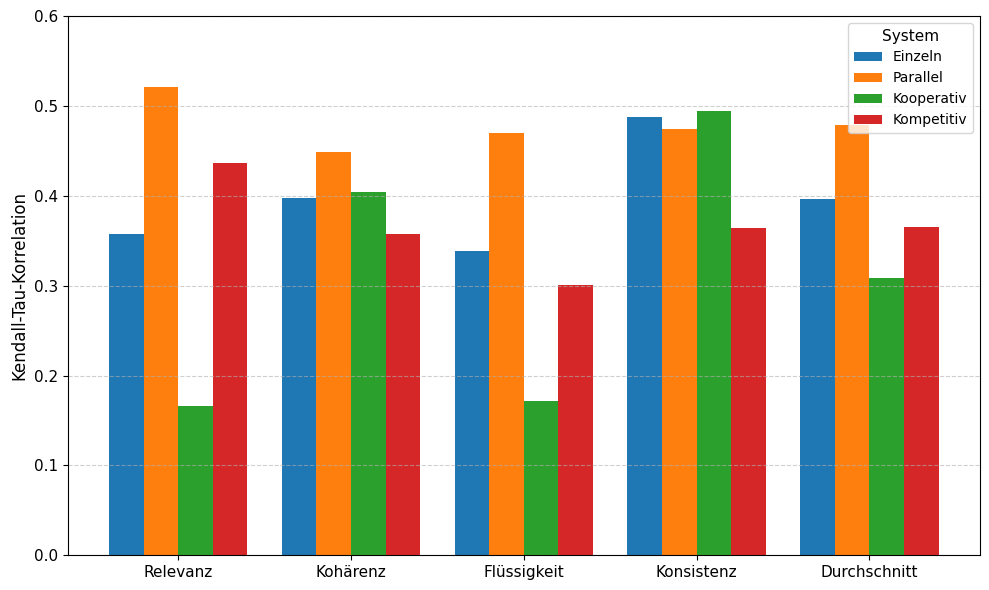

In [18]:
# German labels for dimensions and average
dimension_labels_de = ["Relevanz", "Kohärenz", "Flüssigkeit", "Konsistenz", "Durchschnitt"]
dimensions = ["relevance", "coherence", "fluency", "consistency", "average"]

# Mapping from English system names to German
system_namen_de = {
    "Single": "Einzeln",
    "Parallel": "Parallel",
    "Cooperative": "Kooperativ",
    "Competitive": "Kompetitiv"
}

# Translate system names for display
systems = [system_namen_de[s] for s in kendall_df["system"].tolist()]

x = range(len(dimensions))
bar_width = 0.2
offsets = [-1.5, -0.5, 0.5, 1.5]

plt.figure(figsize=(10, 6))

# Plot bars for each system
for i, orig_system in enumerate(kendall_df["system"]):
    values = kendall_df.loc[kendall_df["system"] == orig_system, dimensions].values.flatten()
    plt.bar(
        [pos + offsets[i] * bar_width for pos in x],
        values,
        width=bar_width,
        label=system_namen_de[orig_system]
    )

# Configure axes and layout
plt.xticks(ticks=x, labels=dimension_labels_de, fontsize=11)
plt.yticks(np.arange(0.0, 0.61, 0.1), fontsize=11)
plt.ylim(0.0, 0.6)
plt.ylabel("Kendall-Tau-Korrelation", fontsize=12)
# plt.title("Vergleich der Kendall-Tau-Korrelation pro Dimension und System", fontsize=13)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(title="System", fontsize=10, title_fontsize=11, loc="upper right")
plt.tight_layout()

plt.show()

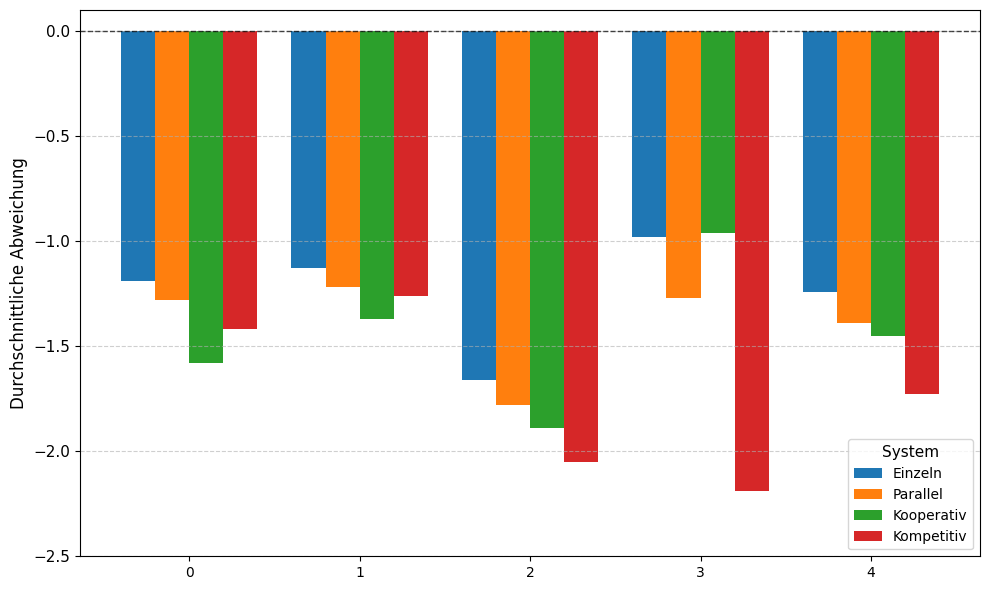

In [19]:
# German labels for dimensions and average
dimension_labels_de = ["Relevanz", "Kohärenz", "Flüssigkeit", "Konsistenz", "Durchschnitt"]
dimensions = ["relevance", "coherence", "fluency", "consistency", "average"]

# Mapping from English system names to German
system_namen_de = {
    "Single": "Einzeln",
    "Parallel": "Parallel",
    "Cooperative": "Kooperativ",
    "Competitive": "Kompetitiv"
}

# Extract German system names for display
systems = [system_namen_de[s] for s in deviation_df["system"].tolist()]

x = range(len(dimensions))
bar_width = 0.2
offsets = [-1.5, -0.5, 0.5, 1.5]

plt.figure(figsize=(10, 6))

# Plot bars for each system
for i, orig_system in enumerate(deviation_df["system"]):
    values = deviation_df.loc[deviation_df["system"] == orig_system, dimensions].values.flatten()
    plt.bar(
        [pos + offsets[i] * bar_width for pos in x],
        values,
        width=bar_width,
        label=system_namen_de[orig_system]
    )

# Configure axes and layout
plt.yticks(np.arange(-2.5, 0.1, 0.5), fontsize=11)
plt.ylim(-2.5, 0.1)
plt.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.7)
plt.ylabel("Durchschnittliche Abweichung", fontsize=12)
# plt.title("Vergleich der Durchschnittlichen Abweichung pro Dimension und System", fontsize=13)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(title="System", fontsize=10, title_fontsize=11, loc="lower right")
plt.tight_layout()

plt.show()